In [19]:

import os
import sys

import numpy
from pathlib import Path

import aps
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import focusing_optics_factory_method, ExecutionMode
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import get_default_input_features, Layout
from aps.ai.autoalignment.beamline28IDB.hardware.epics.focusing_optics import DISTANCE_V_MOTORS

from aps.ai.autoalignment.common.facade.parameters import Movement, AngularUnits, DistanceUnits

from aps.ai.autoalignment.common.util.common import PlotMode, AspectRatio, ColorMap
from aps.ai.autoalignment.common.util.wrappers import plot_distribution, load_beam
from aps.ai.autoalignment.common.util.shadow.common import PreProcessorFiles
from aps.ai.autoalignment.common.util import clean_up

from aps.ai.autoalignment.common.util.wrappers import EXPERIMENTAL_NOISE_TO_SIGNAL_RATIO
from aps.ai.autoalignment.common.util.wrappers import get_distribution_info 


In [2]:

from epics import ca
ca.finalize_libca()

import matplotlib as mpl

%matplotlib inline

In [3]:

def get_v_bimorph_mirror_motor_pitch(di, do, u):
    return numpy.degrees(numpy.arcsin((di - get_v_bimorph_mirror_motor_translation(do, u)) /
                                      (0.5 * DISTANCE_V_MOTORS)))

def get_v_bimorph_mirror_motor_translation(do, u):
    return 0.5 * (u + do)


In [5]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [77]:
verbose = False

plot_mode = PlotMode.INTERNAL
aspect_ratio = AspectRatio.CARTESIAN
color_map = ColorMap.VIRIDIS

nbins_h = 2160
nbins_v = 2560

detector_x = nbins_h * 0.65 * 1e-3
detector_y = nbins_v * 0.65 * 1e-3

x_range = [-detector_x/2, detector_x/2]
y_range = [-detector_y/2, detector_y/2]

add_noise = False #True
noise     = EXPERIMENTAL_NOISE_TO_SIGNAL_RATIO * 70

setup_work_dir()

clean_up()

input_beam = load_beam(Implementors.SHADOW, "primary_optics_system_beam.dat")

In [78]:
 # Focusing Optics System -------------------------

focusing_system = focusing_optics_factory_method(execution_mode=ExecutionMode.SIMULATION, implementor=Implementors.SHADOW, bender=True)
focusing_system.initialize(input_photon_beam=input_beam,
                           input_features=get_default_input_features(layout=Layout.AUTO_FOCUSING),
                           rewrite_preprocessor_files=PreProcessorFiles.NO,
                           layout=Layout.AUTO_FOCUSING)

print("Nr Shadow Rays: " + str(len(input_beam._beam.rays[numpy.where(input_beam._beam.rays[:, 9]==1)])))

Nr Shadow Rays: 8275


In [79]:
random_seed = 2120 # for repeatability


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


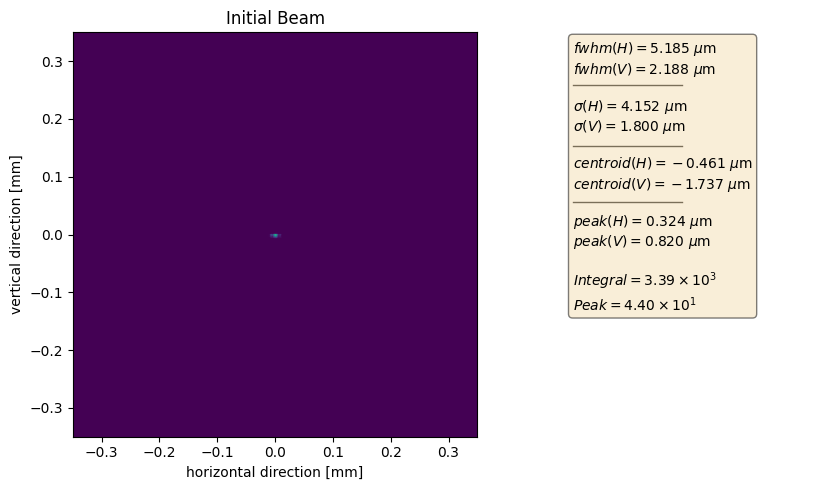

In [80]:
output_beam = focusing_system.get_photon_beam(near_field_calculation=True, verbose=verbose, debug_mode=False, random_seed=random_seed)
plot_distribution(Implementors.SHADOW, output_beam,
                      xrange=[-0.35,0.35], yrange=[-0.35,0.35], nbins_h=nbins_h // 2, nbins_v=nbins_v // 2,
                      title="Initial Beam",
                      plot_mode=plot_mode, aspect_ratio=aspect_ratio, color_map=color_map, add_noise=add_noise, noise=noise)


In [81]:
hist, dw = get_distribution_info(implementor=Implementors.SHADOW,
            beam=output_beam,
            xrange=x_range,
            yrange=y_range,
            nbins_h=nbins_h,
            nbins_v=nbins_v,
            do_gaussian_fit=False,
            add_noise=False
        )

In [82]:
import cmasher as cmm

In [83]:
m2 = cmm.get_sub_cmap(cmm.sunburst_r, 0, 0.5)

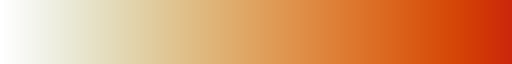

In [84]:
m2

In [85]:
m2.set_bad('w')

In [86]:
hist.vv[hist.vv.size // 2 - 1], hist.hh[hist.hh.size//2 - 1]

(-0.0003249999999999642, -0.0003249999999999642)

In [87]:
hist.data_2D[hist.hh.size//2 - 1, hist.vv.size//2 -1]

50.49738091814389

In [88]:
np.argmax(hist.data_2D)

2766079

In [89]:
np.unravel_index(np.argmax(hist.data_2D), hist.data_2D.shape)

(1080, 1279)

In [90]:
hist.hh.size // 2

1080

In [91]:
hist.vv.size//2 

1280

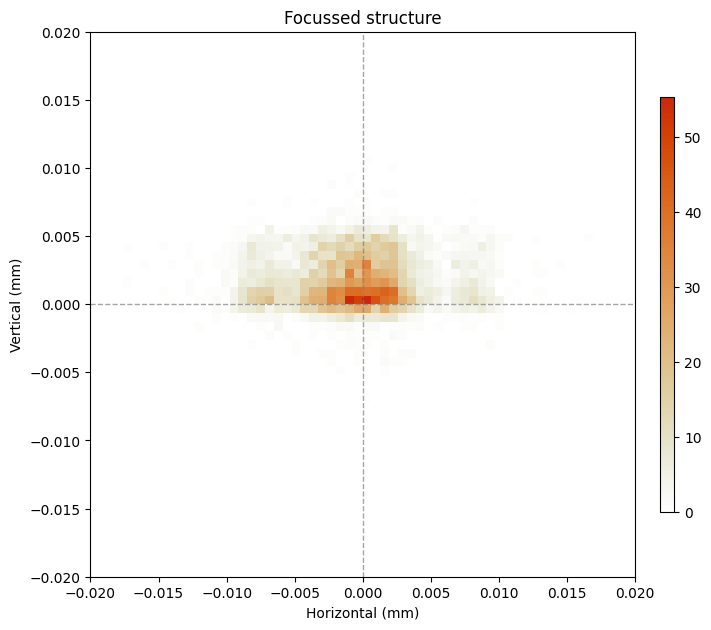

In [110]:
dwd = dw._DictionaryWrapper__dictionary

plt.figure(figsize=[7,7], constrained_layout=True)



plt.xlim(-0.02,0.02)
plt.ylim(-0.02,0.02)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
#plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, rasterized=False)#, norm=mpl.colors.LogNorm(1, 4e2))
plt.imshow(hist.data_2D.T, cmap=m2, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))

plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Focussed structure")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dwd['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dwd['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dwd['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dwd['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dwd['peak_intensity']: 3.2e} ph")
#ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
#        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
plt.show()

In [ ]:

if __name__ == "__main__":
    

   

    # ----------------------------------------------------------------
    # perturbation of the incident beam to make adjustements necessary

    random_seed = 2120 # for repeatability

    focusing_system.perturbate_input_photon_beam(shift_h=0.0, shift_v=0.0)

    '''
    hb 1    (V)  :-170.0
    hb 2    (V)  :-157.0
    hb pitch (deg):0.17164
    hb trans (deg):0.0
    vb       (V)  :384.0
    vb (mm)       : 0.54126, 0.54126, -0.54126
    '''

    focusing_system.move_h_bendable_mirror_motor_1_bender(-167,   movement=Movement.ABSOLUTE)
    focusing_system.move_h_bendable_mirror_motor_2_bender(-160,   movement=Movement.ABSOLUTE)
    focusing_system.move_h_bendable_mirror_motor_pitch(0.17189,   movement=Movement.ABSOLUTE, units=AngularUnits.DEGREES)
    focusing_system.move_h_bendable_mirror_motor_translation(0.0, movement=Movement.ABSOLUTE, units=DistanceUnits.MILLIMETERS)

    focusing_system.move_v_bimorph_mirror_motor_bender(417, movement=Movement.ABSOLUTE) # vertical focus
    focusing_system.move_v_bimorph_mirror_motor_pitch(get_v_bimorph_mirror_motor_pitch(0.54126, 0.54126, -0.54126),    movement=Movement.ABSOLUTE, units=AngularUnits.DEGREES)
    focusing_system.move_v_bimorph_mirror_motor_translation(get_v_bimorph_mirror_motor_translation(0.54126, -0.54126), movement=Movement.ABSOLUTE, units=DistanceUnits.MILLIMETERS)

    print(focusing_system.get_h_bendable_mirror_q_distance(), focusing_system.get_v_bimorph_mirror_q_distance())

    output_beam = focusing_system.get_photon_beam(near_field_calculation=True, verbose=verbose, debug_mode=False, random_seed=random_seed)

    plot_distribution(Implementors.SHADOW, output_beam,
                      xrange=x_range, yrange=y_range, nbins_h=nbins_h, nbins_v=nbins_v,
                      title="Initial Beam",
                      plot_mode=plot_mode, aspect_ratio=aspect_ratio, color_map=color_map, add_noise=add_noise, noise=noise)


    
